# Decision Tree

- Decision Node: condition
- Leaf Node: class value
- Sub Tree

Decision Tree - first makes condition that can choose data set which has high data uniformity

how to measure data uniformity?
- Information Gain: 1 - Entropy
- Genie: 0 (Fair) ~ 1 (Unfair)

Scikit Learn's Decision Tree
```
if all Data set's classification is done:
    stop recursive
else:
    if Data set's all item is in the same classification:
        make Leaf Node
    else:
        Find which is the most efficient way to divide data set (based on Information Gain, Genie)
        Create Branch Node based on previous job
```

Decision Tree has a problem of...
- Overfitting: because it makes all of Nodes until all dataset can be classified by tree

DecisionTreeClassifier parameter
- min_samples_split: sample data (prevents overfitting)
- min_samples_leaf: minimum sample data that leaf node should have
- max_features: sets maximum feature counts (int, sqrt, auto(same as sqrt), log, None)
- max_depth: sets maximum depth of tree
- max_leaf_nodes: leaf node's maximum amount

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

dt_clf = DecisionTreeClassifier(random_state=156)

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target,
                                                    test_size=0.2, random_state=11)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [2]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names, \
                feature_names=iris_data.feature_names, impurity=True, filled=True)

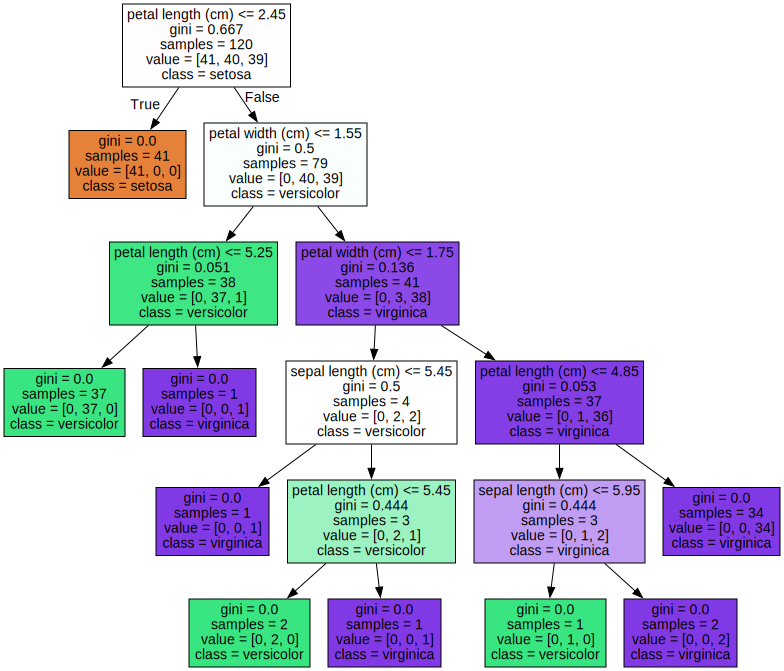

In [3]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

leaf node: the node that does not have child node

### Node structure
condition: condition to make child node
gini: gini value
samples: data sample counts
value: class separated data counts
class: means the node has only that class data(if it is a leaf node), or the node has mostly that class data

max_depth changes the max depth of tree (prevents overfitting)
min_samples_split sets the limit of minimum samples
min_samples_leaf sets the limit of minimum samples of leaf nodes

#### feature_importances_
shows importance of each features (based on information gain or genie)

Feature importances:[0.025 0.    0.555 0.42 ]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


<AxesSubplot:>

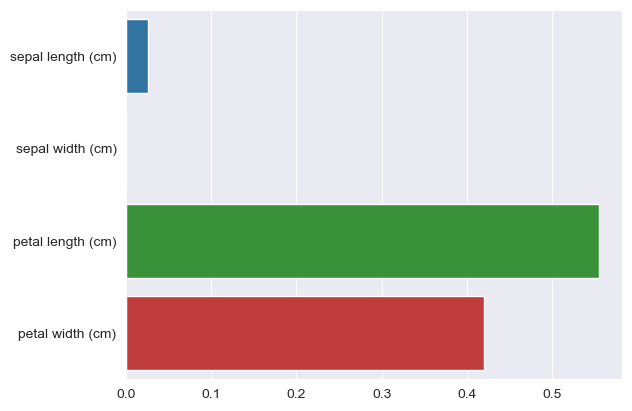

In [4]:
import seaborn as sns
import numpy as np
%matplotlib inline

# extract feature importance
print("Feature importances:{0}".format(np.round(dt_clf.feature_importances_, 3)))

# mapping importance
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print("{0} : {1:.3f}".format(name, value))

sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

### Decision Tree Overfitting

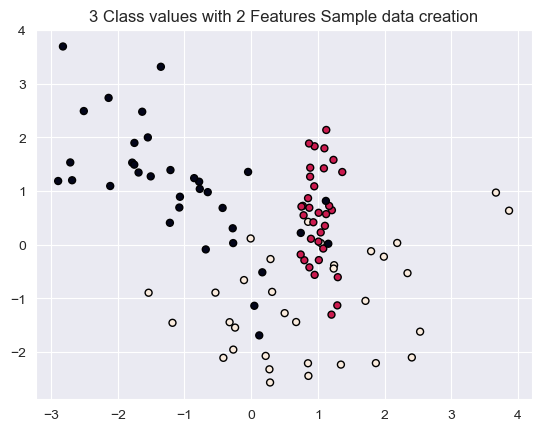

In [6]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("3 Class values with 2 Features Sample data creation")

# make arbitrary data set
X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                           n_classes=3, n_clusters_per_class=1, random_state=0)

plt.scatter(X_features[:, 0], X_features[:, 1], marker="o", c=y_labels, s=25, edgecolors="k")

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=156).fit(X_features, y_labels)

In [9]:
# Visualize Decision Boundary

def visualize_boundary(model, X, y):
    fig, ax = plt.subplots()

    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap="rainbow", edgecolor="k",
               clim=(y.min(), y.max()), zorder=3)
    ax.axis("tight")
    ax.axis("off")

    xlim_start, xlim_end = ax.get_xlim()
    ylim_start, ylim_end = ax.get_ylim()

    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(xlim_start, xlim_end, num=200),
                         np.linspace(ylim_start, ylim_end, num=200))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap="rainbow", clim=(y.min(), y.max()),
                           zorder=1)

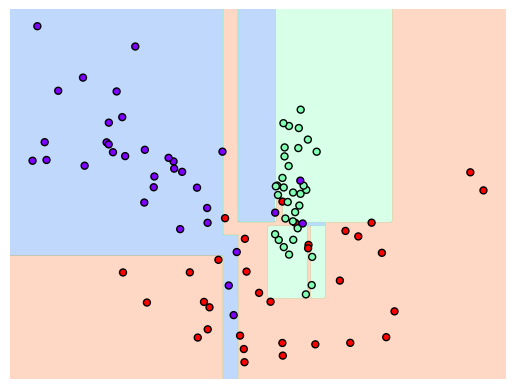

In [10]:
visualize_boundary(dt_clf, X_features, y_labels)

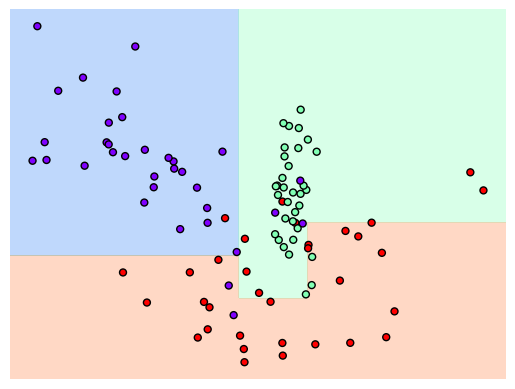

In [11]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=6, random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

## Human Activity Recognition (using smartphones data set)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv("../human_activity/features.txt", sep="\s+",
                              header=None, names=["column_index", "column_name"])

feature_name = feature_name_df.iloc[:, 1].values.tolist()
print("feature 10 samples:", feature_name[:10])

feature 10 samples: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [13]:
# check duplicates
feature_dup_df = feature_name_df.groupby("column_name").count()
print(feature_dup_df[feature_dup_df["column_index"] > 1].count())
feature_dup_df[feature_dup_df["column_index"] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [14]:
# this returns old features that has duplicates to new features
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby("column_name").cumcount(),
                                  columns=["dup_cnt"])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how="outer")
    new_feature_name_df["column_name"] = new_feature_name_df[["column_name", "dup_cnt"]]\
        .apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(["index"], axis=1)
    return new_feature_name_df

In [24]:
import pandas as pd

def get_human_dataset():
    feature_name_df = pd.read_csv("../human_activity/features.txt", sep="\s+",
                                  header=None, names=["column_index", "column_name"])

    # calls get_new_feature_name_df
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    X_train = pd.read_csv("../human_activity/train/X_train.txt", sep="\s+", names=feature_name)
    X_test = pd.read_csv("../human_activity/test/X_test.txt", sep="\s+", names=feature_name)

    y_train = pd.read_csv("../human_activity/train/y_train.txt", sep="\s+", header=None,  names=["action"])
    y_test = pd.read_csv("../human_activity/test/y_test.txt", sep="\s+", header=None, names=["action"])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [25]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [26]:
print(y_train["action"].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("accuracy: {0:.4f}".format(accuracy))

print("DecisionTreeClassifier default hyper parameter:", dt_clf.get_params())

accuracy: 0.8548
DecisionTreeClassifier default hyper parameter: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [28]:
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth" : [6, 8, 10, 12, 16, 20, 24],
    "min_samples_split": [16]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring="accuracy", cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print("GridSearchCV best accuracy: {0:.4f}".format(grid_cv.best_score_))
print("GeidSearchCV hyper parameter: {0}".format(grid_cv.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV best accuracy: 0.8549
GeidSearchCV hyper parameter: {'max_depth': 8, 'min_samples_split': 16}


In [29]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[["param_max_depth", "mean_test_score"]]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [30]:
max_depths = [6, 8, 10, 12, 16, 20, 24]

for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print("max_depth = {0} accuracy: {1:.4f}".format(depth, accuracy))

max_depth = 6 accuracy: 0.8551
max_depth = 8 accuracy: 0.8717
max_depth = 10 accuracy: 0.8599
max_depth = 12 accuracy: 0.8571
max_depth = 16 accuracy: 0.8599
max_depth = 20 accuracy: 0.8565
max_depth = 24 accuracy: 0.8565


In [31]:
params = {
    "max_depth": [8, 12, 16, 20],
    "min_samples_split": [16, 24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring="accuracy", cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print("GridSearchCV best mean accuracy: {0:.4f}".format(grid_cv.best_score_))
print("GridSearchCV best hyper parameter: {0}".format(grid_cv.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV best mean accuracy: 0.8549
GridSearchCV best hyper parameter: {'max_depth': 8, 'min_samples_split': 16}


In [32]:
best_df_clf = grid_cv.best_estimator_
prd1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, prd1)
print("Decision Tree prediction accuracy: {0:.4f}".format(accuracy))

Decision Tree prediction accuracy: 0.8717


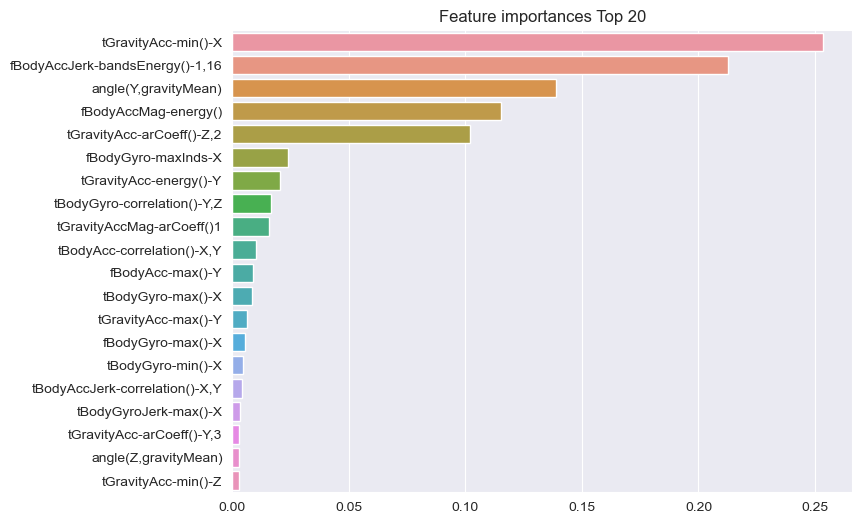

In [33]:
import seaborn as sns

ftr_importance_values = best_df_clf.feature_importances_

# to Series
ftr_importance = pd.Series(ftr_importance_values, index=X_train.columns)

# arrange as importance
ftr_top20 = ftr_importance.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title("Feature importances Top 20")
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()